In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Setting up the Spark Session

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

!java -version
!sudo update-alternatives --config java
!java -version

openjdk version "11.0.4" 2019-07-16
OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3)
OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (b

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Importing the libraries

In [0]:
#importing libraries for spark mllib 
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

from operator import itemgetter
from itertools import groupby
import pandas as pd

from datetime import datetime

# Sampling the data - Ratings of the top 500 movies from users that have rated more than 1500 movies 

In [0]:
ratingsData = spark.read.load("/content/drive/My Drive/ml-20m/ratings.csv",format="csv",header=True,inferSchema=True)
#ratingsData.show(5)

In [0]:
ratingsDataByCount = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

In [0]:
ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

In [0]:
#selecting the top 500 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(500)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

In [0]:
ratingsData_1.count()

12840344

In [0]:
ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_2 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

In [0]:
ratingsData_2.count()

220683

# Splitting into training tune (for validation) and test in the ratio 60:20:20




In [0]:
(training, tune,  test) = ratingsData_2.randomSplit([0.6, 0.2, 0.2])

# Tuning hyper-paramters for variations in latent factors, $\lambda$ and number of iterations for sample 1

In [0]:
#from pyspark import SparkConf, SparkContext
#from pyspark.mllib.recommendation import ALS
import itertools
from math import sqrt
import sys
from operator import add

ranks       = [10,20,30,40]
lambdas     = [0.1,0.05,0.01]
numIters    = [5,10]
temp = []
result = []
bestModel   = None
bestRmse = float("inf")
bestRank    = 0
bestLambda  = -1.0
bestNumIter = -1
for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
  als = ALS(maxIter=numIter, regParam=lmbda, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop",implicitPrefs=False, rank=rank)
  model = als.fit(training)
  predictions = model.transform(tune)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  temp.append(rank)
  temp.append(lmbda)
  temp.append(numIter)
  temp.append(rmse)
  result.append(temp)
  temp = []
  print (rank, lmbda, numIter, rmse)
  if (rmse < bestRmse):
    bestModel = model
    bestRmse = rmse
    bestRank = rank
    bestLambda = lmbda
    bestNumIter = numIter
print (bestRank, bestLambda, bestNumIter, bestRmse) 
print ("ALS on train:\t\t%.2f" % bestRmse)


10 0.1 5 0.8160859379459205
10 0.1 10 0.7849230628326624
10 0.05 5 0.7708320761059118
10 0.05 10 0.7586621504625916
10 0.01 5 0.7628326805613859
10 0.01 10 0.7612962521829573
20 0.1 5 0.7961043044534777
20 0.1 10 0.7801798096896694
20 0.05 5 0.7570650712665437
20 0.05 10 0.75220548804692
20 0.01 5 0.799272000684054
20 0.01 10 0.7969249720658184
30 0.1 5 0.7841414171305277
30 0.1 10 0.7766675804254443
30 0.05 5 0.7518956000523962
30 0.05 10 0.7510813852634157
30 0.01 5 0.8278028220022701
30 0.01 10 0.8356059574830945
40 0.1 5 0.784047384889419
40 0.1 10 0.7766278658891899
40 0.05 5 0.7534718568184552
40 0.05 10 0.7537700478869277
40 0.01 5 0.8592953037083585
40 0.01 10 0.8705286103566345
30 0.05 10 0.7510813852634157
ALS on train:		0.75


In [120]:
print(result)

[[10, 0.1, 5, 0.8160859379459205], [10, 0.1, 10, 0.7849230628326624], [10, 0.05, 5, 0.7708320761059118], [10, 0.05, 10, 0.7586621504625916], [10, 0.01, 5, 0.7628326805613859], [10, 0.01, 10, 0.7612962521829573], [20, 0.1, 5, 0.7961043044534777], [20, 0.1, 10, 0.7801798096896694], [20, 0.05, 5, 0.7570650712665437], [20, 0.05, 10, 0.75220548804692], [20, 0.01, 5, 0.799272000684054], [20, 0.01, 10, 0.7969249720658184], [30, 0.1, 5, 0.7841414171305277], [30, 0.1, 10, 0.7766675804254443], [30, 0.05, 5, 0.7518956000523962], [30, 0.05, 10, 0.7510813852634157], [30, 0.01, 5, 0.8278028220022701], [30, 0.01, 10, 0.8356059574830945], [40, 0.1, 5, 0.784047384889419], [40, 0.1, 10, 0.7766278658891899], [40, 0.05, 5, 0.7534718568184552], [40, 0.05, 10, 0.7537700478869277], [40, 0.01, 5, 0.8592953037083585], [40, 0.01, 10, 0.8705286103566345]]


# Calculating accuracy of predictions on the test data


In [53]:
#Testing it on the test data
start = datetime.now()
print("Start Time =", start)
als = ALS(maxIter=10, regParam=0.05, 
          userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop",
          implicitPrefs=False, rank=30)
model = als.fit(training)
end = datetime.now()
print("End Time =", end)
time_1 = (end - start).total_seconds()
print(time_1)

Start Time = 2019-11-06 18:08:07.200521
End Time = 2019-11-06 18:09:38.343619
91.143098


In [15]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
rmse_1 = rmse
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.7588650990913113


In [196]:
#calculating r2 as the secondary metric
evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")

r2 = evaluator.evaluate(predictions)
r2_1 = r2
print("Root-squared error = " + str(r2))

Root-squared error = 0.4521731473926345


# Coverage for Sample 1

In [16]:
pandasDf = ratingsData_2.toPandas()

Recs = model.recommendForAllUsers(pandasDf['movieId'].nunique())
rec_movies_1 = Recs.toPandas()

list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

#Finding out the top 10 movies based on predicted rating values for movies user hasn't seen.
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

Coverage_movies_1 = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies =" + str(Coverage_movies_1) )

list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 

Coverage_users_1 = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users =" + str(Coverage_users_1))

Coverage of movies =0.818
Coverage based on users =0.7962003454231433


# Increasing the sample size (taking the top 1000 movies) and tuning the paramteres based for that size

In [0]:
ratingsDataByCount_1 = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

In [0]:
ratingsDataByCount_1 = ratingsDataByCount_1.sort('count', ascending=False)

In [0]:
#selecting the top 1000 most popular movie 
ratingsDataByCount_1 = ratingsDataByCount_1.limit(1000)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByCount_1.createOrReplaceTempView("ratingsDataByCount_1")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount_1 where ratingsData.movieId = ratingsDataByCount_1.movieId")

In [0]:
ratingsDataByUserCount_1 = ratingsData.groupby('userId').count()
ratingsDataByUserCount_1 = ratingsDataByUserCount.sort('count', ascending=False)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount_1.createOrReplaceTempView("ratingsDataByUserCount_1")
ratingsData_1_1.createOrReplaceTempView("ratingsData_1_1")

ratingsData_2_1 = spark.sql("SELECT ratingsData_1_1.movieId, ratingsData_1_1.userId, ratingsData_1_1.rating FROM ratingsDataByUserCount_1, ratingsData_1_1 WHERE ratingsData_1_1.userId = ratingsDataByUserCount_1.userId and ratingsDataByUserCount_1.count > 1500")

In [0]:
ratingsData_2_1.count()

387079

# Splitting into training tune (for validation) and test in the ratio 60:20:20




In [0]:
(training_1, tune_1,  test_1) = ratingsData_2_1.randomSplit([0.6, 0.2, 0.2])

# Tuning hyper-paramters for the sample 2


In [121]:
#from pyspark import SparkConf, SparkContext
#from pyspark.mllib.recommendation import ALS
import itertools
from math import sqrt
import sys
from operator import add

ranks       = [10,20,30,40]
lambdas     = [0.1,0.05,0.01]
numIters    = [5,10]
temp_1 = []
result_1 = []
bestModel   = None
bestRmse = float("inf")
bestRank    = 0
bestLambda  = -1.0
bestNumIter = -1
for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
  als = ALS(maxIter=numIter, regParam=lmbda, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop",implicitPrefs=False, rank=rank)
  model = als.fit(training_1)
  predictions = model.transform(tune_1)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  temp_1.append(rank)
  temp_1.append(lmbda)
  temp_1.append(numIter)
  temp_1.append(rmse)
  result_1.append(temp)
  temp_1 = []
  print (rank, lmbda, numIter, rmse)
  if (rmse < bestRmse):
    bestModel = model
    bestRmse = rmse
    bestRank = rank
    bestLambda = lmbda
    bestNumIter = numIter
print (bestRank, bestLambda, bestNumIter, bestRmse) 
print ("ALS on train:\t\t%.2f" % bestRmse)


10 0.1 5 0.8095508332183847
10 0.1 10 0.7836574569156289
10 0.05 5 0.7654743867104711
10 0.05 10 0.7566737164438389
10 0.01 5 0.7608347063789944
10 0.01 10 0.7578559569430581
20 0.1 5 0.7949741455889554
20 0.1 10 0.7804069948914096
20 0.05 5 0.7518872911140863
20 0.05 10 0.7488364215800515
20 0.01 5 0.7834167495167406
20 0.01 10 0.7829571260156953
30 0.1 5 0.7847040323983759
30 0.1 10 0.7773359775049387
30 0.05 5 0.747219853675692
30 0.05 10 0.7470068602487541
30 0.01 5 0.8062156079777897
30 0.01 10 0.8129317666952441
40 0.1 5 0.7846366430407581
40 0.1 10 0.777386974750319
40 0.05 5 0.746761957501748
40 0.05 10 0.7468198199448307
40 0.01 5 0.8307186829843916
40 0.01 10 0.8425029172102276
40 0.05 5 0.746761957501748
ALS on train:		0.75


In [0]:
result_2 = [[10, 0.1, 5, 0.8095508332183847],
[10, 0.1, 10, 0.7836574569156289],
[10, 0.05, 5, 0.7654743867104711],
[10, 0.05, 10, 0.7566737164438389],
[10, 0.01, 5, 0.7608347063789944],
[10, 0.01, 10, 0.7578559569430581],
[20, 0.1, 5, 0.7949741455889554],
[20, 0.1, 10, 0.7804069948914096],
[20, 0.05, 5, 0.7518872911140863],
[20, 0.05, 10, 0.7488364215800515],
[20, 0.01, 5, 0.7834167495167406],
[20, 0.01, 10, 0.7829571260156953],
[30, 0.1, 5, 0.7847040323983759],
[30, 0.1, 10, 0.7773359775049387],
[30, 0.05, 5, 0.747219853675692],
[30, 0.05, 10, 0.7470068602487541],
[30, 0.01, 5, 0.8062156079777897],
[30, 0.01, 10, 0.8129317666952441],
[40, 0.1, 5, 0.7846366430407581],
[40, 0.1, 10, 0.777386974750319],
[40, 0.05, 5, 0.746761957501748],
[40, 0.05, 10, 0.7468198199448307],
[40, 0.01, 5, 0.8307186829843916],
[40, 0.01, 10, 0.8425029172102276]]

# Calculating accuracy of predictions on the test data


In [52]:
#Testing it on the test data
start = datetime.now()
print("Start Time =", start)
als = ALS(maxIter=5, regParam=0.05, 
          userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop",
          implicitPrefs=False, rank=40)
model = als.fit(training_1)
end = datetime.now()
print("End Time =", end)
time_2 = (end - start).total_seconds()
print(time_2)

Start Time = 2019-11-06 18:05:59.669630
End Time = 2019-11-06 18:07:33.680443
94.010813


In [25]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_1)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
rmse_2 = rmse
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.7464014725074214


In [193]:
#calculating r2 as the secondary metric
evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")

r2 = evaluator.evaluate(predictions)
r2_2 = r2
print("Root-squared error = " + str(r2))

Root-squared error = 0.4640072960561281


# Coverage for Sample 2

In [26]:
pandasDf = ratingsData_2_1.toPandas()

Recs = model.recommendForAllUsers(pandasDf['movieId'].nunique())
rec_movies_1 = Recs.toPandas()

list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

#Finding out the top 10 movies based on predicted rating values for movies user hasn't seen.
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

Coverage_movies_2 = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies =" + str(Coverage_movies_2) )

list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 

Coverage_users_2 = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users =" + str(Coverage_users_2))

Coverage of movies =0.58
Coverage based on users =0.8791018998272885


# Increasing the sample size (taking top 1500 movies) and tuning the paramteres based for that size

In [0]:
ratingsDataByCount_2 = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

In [0]:
ratingsDataByCount_2 = ratingsDataByCount_2.sort('count', ascending=False)

In [0]:
#selecting the top 1500 most popular movie 
ratingsDataByCount_2 = ratingsDataByCount_2.limit(1500)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByCount_2.createOrReplaceTempView("ratingsDataByCount_2")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1_2 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount_2 where ratingsData.movieId = ratingsDataByCount_2.movieId")

In [0]:
ratingsDataByUserCount_2 = ratingsData.groupby('userId').count()
ratingsDataByUserCount_2 = ratingsDataByUserCount_2.sort('count', ascending=False)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount_2.createOrReplaceTempView("ratingsDataByUserCount_2")
ratingsData_1_2.createOrReplaceTempView("ratingsData_1_2")

ratingsData_2_2 = spark.sql("SELECT ratingsData_1_2.movieId, ratingsData_1_2.userId, ratingsData_1_2.rating FROM ratingsDataByUserCount_2, ratingsData_1_2 WHERE ratingsData_1_2.userId = ratingsDataByUserCount_2.userId and ratingsDataByUserCount_2.count > 1500")

In [128]:
ratingsData_2_2.count()

517647

# Splitting into training tune (for validation) and test in the ratio 60:20:20




In [0]:
(training_2, tune_2,  test_2) = ratingsData_2_2.randomSplit([0.6, 0.2, 0.2])

# Tuning hyper-paramters for the sample 3


In [130]:
#from pyspark import SparkConf, SparkContext
#from pyspark.mllib.recommendation import ALS
import itertools
from math import sqrt
import sys
from operator import add

ranks       = [10,20,30,40]
lambdas     = [0.1,0.05,0.01]
numIters    = [5,10]
temp_2 = []
result_2 = []
bestModel   = None
bestRmse = float("inf")
bestRank    = 0
bestLambda  = -1.0
bestNumIter = -1
for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
  als = ALS(maxIter=numIter, regParam=lmbda, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop",implicitPrefs=False, rank=rank)
  model = als.fit(training_2)
  predictions = model.transform(tune_2)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  temp_2.append(rank)
  temp_2.append(lmbda)
  temp_2.append(numIter)
  temp_2.append(rmse)
  result_2.append(temp)
  temp_2 = []
  print (rank, lmbda, numIter, rmse)
  if (rmse < bestRmse):
    bestModel = model
    bestRmse = rmse
    bestRank = rank
    bestLambda = lmbda
    bestNumIter = numIter
print (bestRank, bestLambda, bestNumIter, bestRmse) 
print ("ALS on train:\t\t%.2f" % bestRmse)


10 0.1 5 0.8009649734710318
10 0.1 10 0.7776716242920293
10 0.05 5 0.7578781881787031
10 0.05 10 0.7492138124105586
10 0.01 5 0.7539735414341682
10 0.01 10 0.7508281977113563
20 0.1 5 0.7890648437998747
20 0.1 10 0.774713931633738
20 0.05 5 0.7446174640694418
20 0.05 10 0.7412430956669122
20 0.01 5 0.7737210762009116
20 0.01 10 0.7730291213362795
30 0.1 5 0.7793708338674104
30 0.1 10 0.7718753695846621
30 0.05 5 0.7412473570251616
30 0.05 10 0.7405597867231041
30 0.01 5 0.7974460845560601
30 0.01 10 0.8035644202602937
40 0.1 5 0.7791577912745697
40 0.1 10 0.771846955813523
40 0.05 5 0.7403505836932969
40 0.05 10 0.7400964879952823
40 0.01 5 0.8215805840235848
40 0.01 10 0.8311015272576541
40 0.05 10 0.7400964879952823
ALS on train:		0.74


In [0]:
result_3 = [[10, 0.1, 5, 0.8009649734710318],
[10, 0.1, 10, 0.7776716242920293],
[10, 0.05, 5, 0.7578781881787031],
[10, 0.05, 10, 0.7492138124105586],
[10, 0.01, 5, 0.7539735414341682],
[10, 0.01, 10, 0.7508281977113563],
[20, 0.1, 5, 0.7890648437998747],
[20, 0.1, 10, 0.774713931633738],
[20, 0.05, 5, 0.7446174640694418],
[20, 0.05, 10, 0.7412430956669122],
[20, 0.01, 5, 0.7737210762009116],
[20, 0.01, 10, 0.7730291213362795],
[30, 0.1, 5, 0.7793708338674104],
[30, 0.1, 10, 0.7718753695846621],
[30, 0.05, 5, 0.7412473570251616],
[30, 0.05, 10, 0.7405597867231041],
[30, 0.01, 5, 0.7974460845560601],
[30, 0.01, 10, 0.8035644202602937],
[40, 0.1, 5, 0.7791577912745697],
[40, 0.1, 10, 0.771846955813523],
[40, 0.05, 5, 0.7403505836932969],
[40, 0.05, 10, 0.7400964879952823],
[40, 0.01, 5, 0.8215805840235848],
[40, 0.01, 10, 0.8311015272576541]]

# Calculating accuracy of predictions on the test data



In [54]:
#Testing it on the test data
start = datetime.now()
print("Start Time =", start)
als = ALS(maxIter=10, regParam=0.05, 
          userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop",
          implicitPrefs=False, rank=40)
model = als.fit(training_2)
end = datetime.now()
print("End Time =", end)
time_3 = (end - start).total_seconds()
print(time_3)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_2)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
#rmse_3 = rmse
print("Root-mean-square error = " + str(rmse))

Start Time = 2019-11-06 18:10:07.198018
End Time = 2019-11-06 18:11:46.451086
99.253068
Root-mean-square error = 0.7408821070478565


In [190]:
#calculating r2 as the secondary metric
evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")

r2 = evaluator.evaluate(predictions)
r2_3 = r2
print("Root-squared error = " + str(r2))

Root-squared error = 0.4818199959555627


# Coverage for Sample 3

In [35]:
pandasDf = ratingsData_2_2.toPandas()

Recs = model.recommendForAllUsers(pandasDf['movieId'].nunique())
rec_movies_1 = Recs.toPandas()

list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter
                       
#Finding out the top 10 movies based on predicted rating values for movies user hasn't seen.
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

Coverage_movies_3 = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies =" + str(Coverage_movies_3) )

list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 

Coverage_users_3 = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users =" + str(Coverage_users_3))

Coverage of movies =0.4493333333333333
Coverage based on users =0.9119170984455959


# Increasing the sample size (taking the top 2000 movies) and tuning the paramteres based for that size

In [0]:
ratingsDataByCount_3 = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

In [0]:
ratingsDataByCount_3 = ratingsDataByCount_3.sort('count', ascending=False)

In [0]:
#selecting the top 2000 most popular movie 
ratingsDataByCount_3 = ratingsDataByCount_3.limit(2000)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByCount_3.createOrReplaceTempView("ratingsDataByCount_3")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1_3 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount_3 where ratingsData.movieId = ratingsDataByCount_3.movieId")

In [0]:
ratingsDataByUserCount_3 = ratingsData.groupby('userId').count()
ratingsDataByUserCount_3 = ratingsDataByUserCount_3.sort('count', ascending=False)

In [0]:
#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount_3.createOrReplaceTempView("ratingsDataByUserCount_3")
ratingsData_1_3.createOrReplaceTempView("ratingsData_1_3")

ratingsData_2_3 = spark.sql("SELECT ratingsData_1_3.movieId, ratingsData_1_3.userId, ratingsData_1_3.rating FROM ratingsDataByUserCount_3, ratingsData_1_3 WHERE ratingsData_1_3.userId = ratingsDataByUserCount_3.userId and ratingsDataByUserCount_3.count > 1500")

In [137]:
ratingsData_2_3.count()

623192

# Splitting into training tune (for validation) and test in the ratio 60:20:20




In [0]:
(training_3, tune_3, test_3) = ratingsData_2_3.randomSplit([0.6, 0.2, 0.2])

# Tuning hyper-paramters for the sample 4


In [139]:
#from pyspark import SparkConf, SparkContext
#from pyspark.mllib.recommendation import ALS
import itertools
from math import sqrt
import sys
from operator import add

ranks       = [10,20,30,40]
lambdas     = [0.1,0.05,0.01]
numIters    = [5,10]
temp_3 = []
result_3 = []
bestModel   = None
bestRmse = float("inf")
bestRank    = 0
bestLambda  = -1.0
bestNumIter = -1
for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
  als = ALS(maxIter=numIter, regParam=lmbda, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop",implicitPrefs=False, rank=rank)
  model = als.fit(training_3)
  predictions = model.transform(tune_3)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  temp_3.append(rank)
  temp_3.append(lmbda)
  temp_3.append(numIter)
  temp_3.append(rmse)
  result_3.append(temp)
  temp_3 = []
  print (rank, lmbda, numIter, rmse)
  if (rmse < bestRmse):
    bestModel = model
    bestRmse = rmse
    bestRank = rank
    bestLambda = lmbda
    bestNumIter = numIter
print (bestRank, bestLambda, bestNumIter, bestRmse) 
print ("ALS on train:\t\t%.2f" % bestRmse)


10 0.1 5 0.7988163765364675
10 0.1 10 0.7782443073844375
10 0.05 5 0.7573545258887993
10 0.05 10 0.7505198658956018
10 0.01 5 0.7566557347079751
10 0.01 10 0.7537550027696795
20 0.1 5 0.7898549618616025
20 0.1 10 0.7760638366041479
20 0.05 5 0.7478723689429424
20 0.05 10 0.7446067827917199
20 0.01 5 0.7815280441842197
20 0.01 10 0.7815009643028064
30 0.1 5 0.7804653451745364
30 0.1 10 0.7733892011959692
30 0.05 5 0.7432479938959234
30 0.05 10 0.7423358865030417
30 0.01 5 0.8033448372020026
30 0.01 10 0.8096101416955938
40 0.1 5 0.7800640994602744
40 0.1 10 0.7732460779814105
40 0.05 5 0.7428792014710678
40 0.05 10 0.7429209059097138
40 0.01 5 0.8267378436386839
40 0.01 10 0.837624567759108
30 0.05 10 0.7423358865030417
ALS on train:		0.74


In [0]:
result_4 = [[10, 0.1, 5, 0.7988163765364675],
[10, 0.1, 10, 0.7782443073844375],
[10, 0.05, 5, 0.7573545258887993],
[10, 0.05, 10, 0.7505198658956018],
[10, 0.01, 5, 0.7566557347079751],
[10, 0.01, 10, 0.7537550027696795],
[20, 0.1, 5, 0.7898549618616025],
[20, 0.1, 10, 0.7760638366041479],
[20, 0.05, 5, 0.7478723689429424],
[20, 0.05, 10, 0.7446067827917199],
[20, 0.01, 5, 0.7815280441842197],
[20, 0.01, 10, 0.7815009643028064],
[30, 0.1, 5, 0.7804653451745364],
[30, 0.1, 10, 0.7733892011959692],
[30, 0.05, 5, 0.7432479938959234],
[30, 0.05, 10, 0.7423358865030417],
[30, 0.01, 5, 0.8033448372020026],
[30, 0.01, 10, 0.8096101416955938],
[40, 0.1, 5, 0.7800640994602744],
[40, 0.1, 10, 0.7732460779814105],
[40, 0.05, 5, 0.7428792014710678],
[40, 0.05, 10, 0.7429209059097138],
[40, 0.01, 5, 0.8267378436386839],
[40, 0.01, 10, 0.837624567759108]]

# Calculating accuracy of predictions on the test data



In [56]:
#Testing it on the test data
start = datetime.now()
print("Start Time =", start)
als = ALS(maxIter=10, regParam=0.05, 
          userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop",
          implicitPrefs=False, rank=40)
model = als.fit(training_3)
end = datetime.now()
print("End Time =", end)
time_4 = (end - start).total_seconds()
print(time_4)

# Evaluate the model by computing the RMSE on the test data
#predictions = model.transform(test_3)
#evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                #predictionCol="prediction")

#rmse = evaluator.evaluate(predictions)
#rmse_4 = rmse
#print("Root-mean-square error = " + str(rmse))

Start Time = 2019-11-06 18:14:17.847700
End Time = 2019-11-06 18:15:58.829683
100.981983


In [188]:
#calculating r2 as the secondary metric
evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")

r2 = evaluator.evaluate(predictions)
r2_4 = r2
print("Root-squared error = " + str(r2))

Root-squared error = 0.4842083562000332


# Coverage for Sample 4

In [44]:
pandasDf = ratingsData_2_3.toPandas()

Recs = model.recommendForAllUsers(pandasDf['movieId'].nunique())
rec_movies_1 = Recs.toPandas()

list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

#Finding out the top 10 movies based on predicted rating values for movies user hasn't seen.    
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

Coverage_movies_4 = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies =" + str(Coverage_movies_4))

list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 

Coverage_users_4 = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users =" + str(Coverage_users_4))

Coverage of movies =0.3675
Coverage based on users =0.9360967184801382


# Plots

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
df_1 = pd.DataFrame.from_records(result)
df_1.columns = ['Rank','Lambda','NumOfIters','RMSE']

df_2 = pd.DataFrame.from_records(result_2)
df_2.columns = ['Rank','Lambda','NumOfIters','RMSE']

df_3 = pd.DataFrame.from_records(result_3)
df_3.columns = ['Rank','Lambda','NumOfIters','RMSE']

df_4 = pd.DataFrame.from_records(result_4)
df_4.columns = ['Rank','Lambda','NumOfIters','RMSE']

In [0]:
df_1_Rank = df_1.groupby('Rank').min()
df_2_Rank = df_2.groupby('Rank').min()
df_3_Rank = df_3.groupby('Rank').min()
df_4_Rank = df_4.groupby('Rank').min()

# Plot for Ranks vs RMSE - this graph shows us the best value of rank for the different samples 

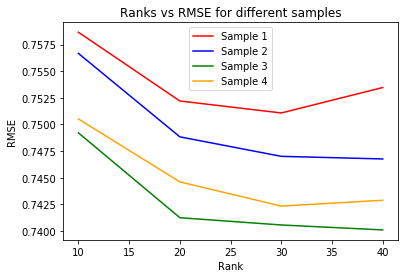

In [161]:
plt.plot(df_1_Rank.index, df_1_Rank['RMSE'], color="red", label="Sample 1")
plt.plot(df_2_Rank.index, df_2_Rank['RMSE'], color="blue", label="Sample 2")
plt.plot(df_3_Rank.index, df_3_Rank['RMSE'], color="green", label="Sample 3")
plt.plot(df_4_Rank.index, df_4_Rank['RMSE'], color="orange", label="Sample 4")

plt.xlabel("Rank")
plt.ylabel("RMSE")

plt.title("Ranks vs RMSE for different samples")
plt.legend(loc="best")

In [0]:
df_1_lambda = df_1.groupby('Lambda').min()
df_2_lambda = df_2.groupby('Lambda').min()
df_3_lambda = df_3.groupby('Lambda').min()
df_4_lambda = df_4.groupby('Lambda').min()

# Plot for Lambda vs RMSE - this graph shows us the best value of lambda for the different samples 

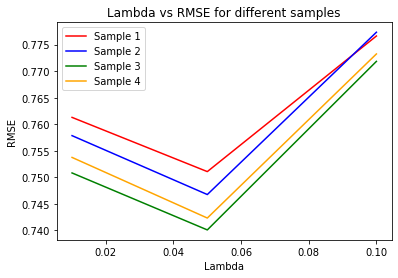

In [163]:
plt.plot(df_1_lambda.index, df_1_lambda['RMSE'], color="red", label="Sample 1")
plt.plot(df_2_lambda.index, df_2_lambda['RMSE'], color="blue", label="Sample 2")
plt.plot(df_3_lambda.index, df_3_lambda['RMSE'], color="green", label="Sample 3")
plt.plot(df_4_lambda.index, df_4_lambda['RMSE'], color="orange", label="Sample 4")

plt.xlabel("Lambda")
plt.ylabel("RMSE")

plt.title("Lambda vs RMSE for different samples")
plt.legend(loc="best")

In [0]:
df_1_numOfIters = df_1.groupby('NumOfIters').min()
df_2_numOfIters = df_2.groupby('NumOfIters').min()
df_3_numOfIters = df_3.groupby('NumOfIters').min()
df_4_numOfIters = df_4.groupby('NumOfIters').min()

# Plot for Number of Iterations vs RMSE - this graph shows us the best value for the number of interations for the different samples 

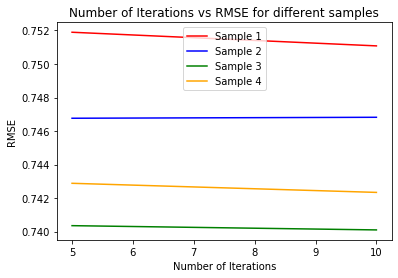

In [168]:
plt.plot(df_1_numOfIters.index, df_1_numOfIters['RMSE'], color="red", label="Sample 1")
plt.plot(df_2_numOfIters.index, df_2_numOfIters['RMSE'], color="blue", label="Sample 2")
plt.plot(df_3_numOfIters.index, df_3_numOfIters['RMSE'], color="green", label="Sample 3")
plt.plot(df_4_numOfIters.index, df_4_numOfIters['RMSE'], color="orange", label="Sample 4")

plt.xlabel("Number of Iterations")
plt.ylabel("RMSE")

plt.title("Number of Iterations vs RMSE for different samples")
plt.legend(loc="best")

# Inference of the plots
The above graphs shows us that the best value for our regression paramter (lambda) is 0.05. 
For ranks the best value comes at either 30 or 40. 
For number of iterations, the best value generally comes at 10. 


# Comparing the accuracy metrics for the different samples 

Text(0.5, 1.0, 'RMSE of the different samples')

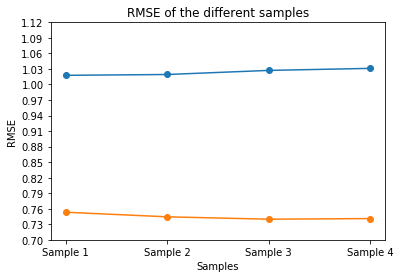

In [221]:
#from the baseline.ipynb we use the following values of our baseline model (evaluation metric = RMSE)
baseline_rmse = [1.0176954407887222, 1.0192983415161732, 1.0271992072986997, 1.031131960344556]
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

baseline_df = pd.DataFrame(baseline_rmse, sample_list)
plt.plot(baseline_df, marker='o')
plt.xlabel("Samples")
plt.ylabel("RMSE")
plt.title("RMSE of the different samples")

rmse_list = [rmse_1, rmse_2, rmse_3, rmse_4]

rmse_df = pd.DataFrame(rmse_list, sample_list)
plt.plot(rmse_df, marker='o')
plt.xlabel("Samples")
plt.ylabel("RMSE")
plt.yticks(np.arange(0.7,1.15,step=0.03))
plt.title("RMSE of the different samples")

Text(0.5, 1.0, 'R2 of the different samples')

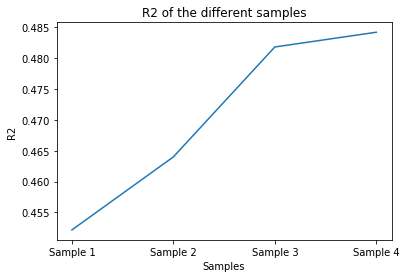

In [199]:
r2_list = [r2_1, r2_2, r2_3, r2_4]

r2_df = pd.DataFrame(r2_list, sample_list)

plt.plot(r2_df)
plt.xlabel("Samples")
plt.ylabel("R2")
plt.title("R2 of the different samples")

# Inference of RMSE and R2 
Here we can see that for all our samples, the model performs better than the baseline. Baseline for the samples is plotted as the blue line and the RMSE for our model is plotted as the orange line. 
For all our samples, the RMSE value is almost the same at approximately ~0.75. 
However, the accuracy does change with change in the sample. 

For R2, the value also changes with change in the sample. For this case, the value of R2 keeps increasing, that means that our model's accuracy becomes better. 

# Running time for training the different samples

Text(0.5, 1.0, 'Running time of the different samples')

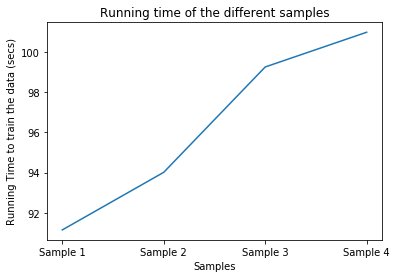

In [57]:
time_list = [time_1, time_2, time_3, time_4]

time_df = pd.DataFrame(time_list, sample_list)

plt.plot(time_df)
plt.xlabel("Samples")
plt.ylabel("Running Time to train the data (secs)")
plt.title("Running time of the different samples")

# Plotting the coverage for our samples

Text(0.5, 1.0, 'Coverage of user for the different samples')

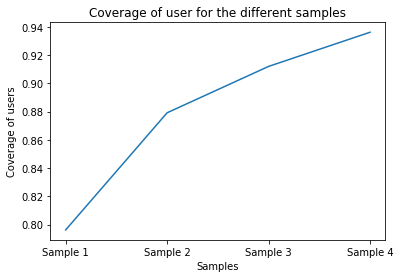

In [46]:
coverage_user_list = [Coverage_users_1, Coverage_users_2, Coverage_users_3, Coverage_users_4]
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

coverage_users_df = pd.DataFrame(coverage_user_list, sample_list)

plt.plot(coverage_users_df)
plt.xlabel("Samples")
plt.ylabel("Coverage of users")
plt.title("Coverage of user for the different samples")

Text(0.5, 1.0, 'Coverage of movies for the different samples')

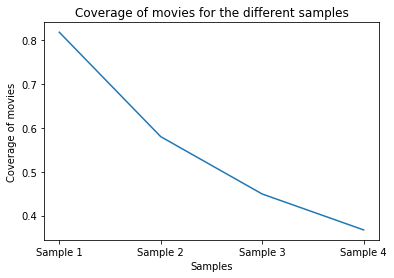

In [48]:
coverage_movies_list = [Coverage_movies_1, Coverage_movies_2, Coverage_movies_3, Coverage_movies_4]

coverage_movies_df = pd.DataFrame(coverage_movies_list, sample_list)

plt.plot(coverage_movies_df)
plt.xlabel("Samples")
plt.ylabel("Coverage of movies")
plt.title("Coverage of movies for the different samples")

The above graphs tell us that as our sample size increases, we are covering more and more users, but we are covering lesser number of movies. 
We think this is the case because we are concentrating more on the popular movies because of which we are leaving out the ones that have been rated lesser number of times. 